<a href="https://colab.research.google.com/github/ramizcihe/week5-cihe240058/blob/main/ramiz_week5_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Step 1: Install required packages
!pip install pandas numpy --quiet

import pandas as pd
import numpy as np
import random

# -------------------------------
# Define labels
# -------------------------------
labels = [
    "not_cyberbullying",
    "ethnicity",
    "gender",
    "age",
    "religion",
    "appearance",
    "other_cyberbullying"
]

# Example text templates for each label
examples = {
    "not_cyberbullying": [
        "Good morning everyone! Stay positive today 😊",
        "Congrats on your promotion, well deserved!",
        "That movie was amazing, I highly recommend it.",
        "I love this new song, it's so catchy.",
        "Have a great day ahead!"
    ],
    "ethnicity": [
        "Go back to your country, you don’t belong here.",
        "People like you ruin this nation.",
        "You speak funny, learn proper English.",
        "No one wants your kind here.",
        "Stop acting superior just because of your race."
    ],
    "gender": [
        "Women can’t play this game, go to the kitchen.",
        "You throw like a girl, pathetic.",
        "Men are always stronger, you’re weak.",
        "No guy would ever want you.",
        "Girls don’t belong in tech."
    ],
    "age": [
        "You’re too old for this app, grandpa.",
        "Kids these days are so dumb.",
        "Nobody listens to old people anymore.",
        "Go play with your toys, child.",
        "You’re ancient, stop embarrassing yourself."
    ],
    "religion": [
        "Your religion is a joke.",
        "People like you should not be allowed here.",
        "Stop spreading your beliefs, nobody cares.",
        "We don’t want your religious nonsense.",
        "Your faith makes no sense at all."
    ],
    "appearance": [
        "You’re so ugly, nobody likes you.",
        "Look at your face, disgusting.",
        "You’re fat and gross.",
        "Your style is trash.",
        "No wonder you’re alone, you’re hideous."
    ],
    "other_cyberbullying": [
        "You play like trash, no skills at all.",
        "You’re the dumbest person I’ve ever met.",
        "Nobody cares about your opinion.",
        "Stop posting nonsense, nobody likes you.",
        "You’re such a loser, go away."
    ]
}

# -------------------------------
# Generate 1000 rows
# -------------------------------
data = []
for i in range(1, 1001):
    label = random.choice(labels)
    text = random.choice(examples[label])
    binary_label = "not_cyberbullying" if label == "not_cyberbullying" else "bullying"
    data.append([i, text, label, binary_label])

# Create DataFrame
df = pd.DataFrame(data, columns=["id", "text", "label", "binary_label"])

# Save to CSV
csv_path = "/content/cyberbullying_dataset.csv"
df.to_csv(csv_path, index=False)
print("✅ Dataset created and saved:", csv_path)
df.head()


✅ Dataset created and saved: /content/cyberbullying_dataset.csv


,id,text,label,binary_label
0,1,"You’re so ugly, nobody likes you.",appearance,bullying
1,2,"That movie was amazing, I highly recommend it.",not_cyberbullying,not_cyberbullying
2,3,People like you ruin this nation.,ethnicity,bullying
3,4,"Go back to your country, you don’t belong here.",ethnicity,bullying
4,5,"No wonder you’re alone, you’re hideous.",appearance,bullying


In [24]:
from google.colab import files
files.download("/content/cyberbullying_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.to_csv("https://raw.githubusercontent.com/ramizcihe/week5-cihe240058/refs/heads/main/cyberbullying_dataset.csv", index=False)


In [25]:
# ===============================
# Step 0: Install & Imports
# ===============================
!pip install transformers datasets evaluate scikit-learn --quiet

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch import nn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate as hf_evaluate
import os

# Disable wandb to avoid login issues
os.environ["WANDB_DISABLED"] = "true"

In [26]:
# ===============================
# Step 1: Load Dataset
# ===============================
# Replace this with your CSV path if needed
CSV_PATH = "https://raw.githubusercontent.com/ramizcihe/week5-cihe240058/refs/heads/main/cyberbullying_dataset.csv"
df = pd.read_csv("https://raw.githubusercontent.com/ramizcihe/week5-cihe240058/refs/heads/main/cyberbullying_dataset.csv")

# Map binary labels to integers
df["binary_label"] = df["binary_label"].replace({
    "not_cyberbullying": 0,
    "bullying": 1
})

print("Sample Dataset:")
print(df.head())

Sample Dataset:
   id                                             text                label  \
0   1                   Look at your face, disgusting.           appearance   
1   2                Your faith makes no sense at all.             religion   
2   3  Stop acting superior just because of your race.            ethnicity   
3   4                          Have a great day ahead!    not_cyberbullying   
4   5                 Nobody cares about your opinion.  other_cyberbullying   

   binary_label  
0             1  
1             1  
2             1  
3             0  
4             1  


/tmp/ipython-input-1254758716.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["binary_label"] = df["binary_label"].replace({


In [27]:
# ===============================
# Step 2: Tokenizer
# ===============================
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [28]:
# ===============================
# Step 3: Dataset Class
# ===============================
class CyberDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

In [29]:
# ===============================
# Step 4: Metrics
# ===============================
metric_acc = hf_evaluate.load("accuracy")
metric_f1  = hf_evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=preds, references=labels, average="binary")["f1"]
    }

In [30]:
# ===============================
# Step 5: Training Arguments
# ===============================
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",   # For older versions of Transformers
    save_strategy="epoch",
    load_best_model_at_end=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [31]:
# ===============================
# Step 6: Custom Weighted Trainer
# ===============================
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [32]:
# ===============================
# Step 7: K-Fold Cross-Validation
# ===============================
print("\n===== Starting 5-Fold Stratified Cross-Validation =====\n")

texts = df["text"].tolist()
labels = df["binary_label"].tolist()
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
acc_scores = []
f1_scores = []

for train_index, val_index in skf.split(texts, labels):
    print(f"\n----- Fold {fold} -----")

    X_train = [texts[i] for i in train_index]
    y_train = [labels[i] for i in train_index]
    X_val   = [texts[i] for i in val_index]
    y_val   = [labels[i] for i in val_index]

    # Create datasets
    train_ds = CyberDataset(X_train, y_train, tokenizer)
    val_ds   = CyberDataset(X_val, y_val, tokenizer)

    # Compute class weights
    cw = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_tensor = torch.tensor(cw, dtype=torch.float)
    print("Class weights for this fold:", class_weights_tensor)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    # Initialize trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        class_weights=class_weights_tensor
    )

    # Train
    trainer.train()

    # Evaluate
    metrics = trainer.evaluate()
    print(f"Fold {fold} Accuracy: {metrics['eval_accuracy']:.4f}, F1: {metrics['eval_f1']:.4f}")
    acc_scores.append(metrics["eval_accuracy"])
    f1_scores.append(metrics["eval_f1"])

    fold += 1

print("\n===== K-Fold Cross-Validation Completed =====")
print("Average Accuracy:", np.mean(acc_scores))
print("Average F1-score:", np.mean(f1_scores))


===== Starting 5-Fold Stratified Cross-Validation =====


----- Fold 1 -----
Class weights for this fold: tensor([3.2258, 0.5917])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.637100,0.581471,1.000000,1.000000
2,0.094900,0.050656,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1 Accuracy: 1.0000, F1: 1.0000

----- Fold 2 -----
Class weights for this fold: tensor([3.2520, 0.5908])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.630000,0.596931,1.000000,1.000000
2,0.116100,0.060555,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2 Accuracy: 1.0000, F1: 1.0000

----- Fold 3 -----
Class weights for this fold: tensor([3.2520, 0.5908])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.633200,0.583611,1.000000,1.000000
2,0.088700,0.048874,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fold 3 Accuracy: 1.0000, F1: 1.0000

----- Fold 4 -----
Class weights for this fold: tensor([3.2520, 0.5908])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.626800,0.577551,1.000000,1.000000
2,0.090100,0.048382,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fold 4 Accuracy: 1.0000, F1: 1.0000

----- Fold 5 -----
Class weights for this fold: tensor([3.2520, 0.5908])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.631500,0.581653,1.000000,1.000000
2,0.102400,0.051777,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fold 5 Accuracy: 1.0000, F1: 1.0000

===== K-Fold Cross-Validation Completed =====
Average Accuracy: 1.0
Average F1-score: 1.0



📂 Fold 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.406400
20,0.132200
30,0.026300
40,0.006500
50,0.004500
60,0.003100
70,0.002100
80,0.001800
90,0.001700
100,0.001900


📊 Eval Results Fold 1: {'eval_loss': 0.001222901395522058, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_runtime': 18.6048, 'eval_samples_per_second': 26.875, 'eval_steps_per_second': 1.72, 'epoch': 2.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


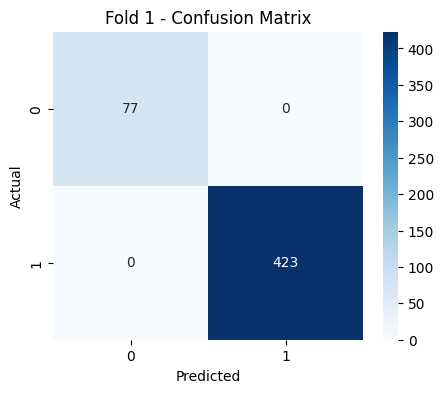

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


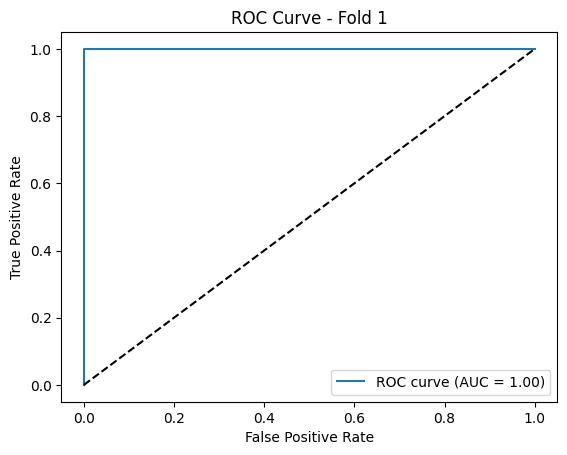


📂 Fold 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.488100
20,0.122300
30,0.028600
40,0.015600
50,0.005100
60,0.004100
70,0.003200
80,0.002500
90,0.002200
100,0.002000


📊 Eval Results Fold 2: {'eval_loss': 0.0014179146382957697, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_runtime': 12.3013, 'eval_samples_per_second': 40.646, 'eval_steps_per_second': 2.601, 'epoch': 2.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


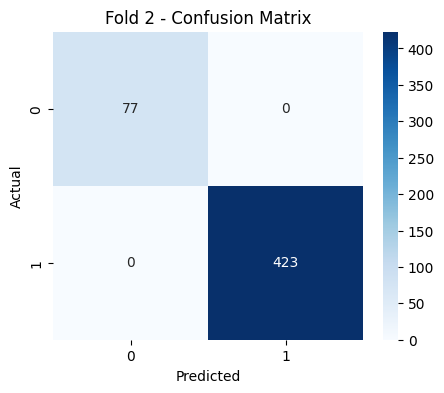

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


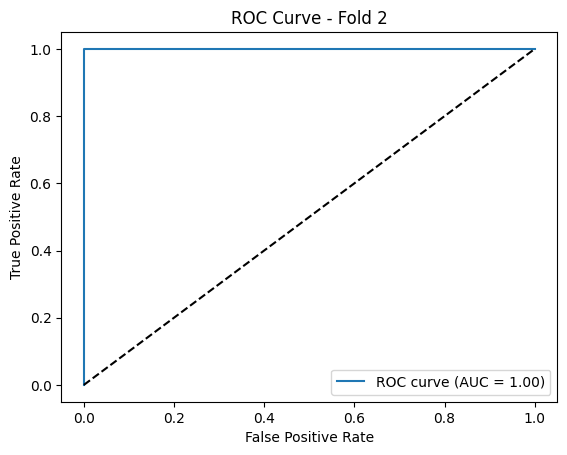

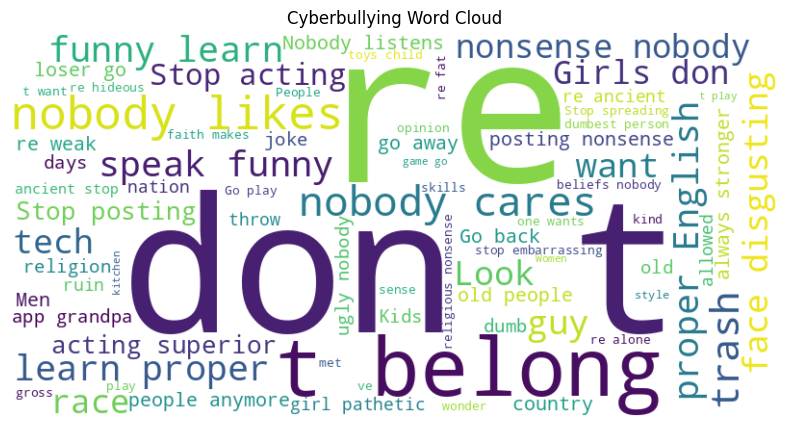

In [42]:
# ✅ All-in-One Code Cell (No evaluation_strategy, compatible with old transformers)
!pip install -U transformers datasets textblob wordcloud --quiet

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
from textblob import TextBlob
from wordcloud import WordCloud

# Load dataset
url = "https://raw.githubusercontent.com/ramizcihe/week5-cihe240058/refs/heads/main/cyberbullying_dataset.csv"
df = pd.read_csv(url)
df["binary_label"] = df["label"].apply(lambda x: 0 if x == "not_cyberbullying" else 1)
df["sentiment"] = df["text"].apply(lambda x: round(TextBlob(x).sentiment.polarity, 2))
df["bigram"] = df["text"].apply(lambda x: " ".join([x.split()[i] + "_" + x.split()[i+1] for i in range(len(x.split())-1)]))

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

class CyberDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare data
texts = df["text"].values
labels = df["binary_label"].values
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), 1):
    print(f"\n📂 Fold {fold}")
    X_train, X_val = texts[train_idx], texts[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    train_dataset = CyberDataset(X_train.tolist(), y_train.tolist())
    val_dataset = CyberDataset(X_val.tolist(), y_val.tolist())

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        logging_dir=f"./logs_fold_{fold}",
        logging_steps=10,
        save_strategy="no"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        report = classification_report(labels, preds, output_dict=True)
        return {"accuracy": report["accuracy"], "f1": report["1"]["f1-score"]}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(f"📊 Eval Results Fold {fold}: {eval_results}")

    preds = trainer.predict(val_dataset).predictions
    preds = np.argmax(preds, axis=1)
    cm = confusion_matrix(y_val, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    probs = torch.nn.functional.softmax(torch.tensor(trainer.predict(val_dataset).predictions), dim=1)[:,1].numpy()
    fpr, tpr, _ = roc_curve(y_val, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Fold {fold}')
    plt.legend(loc='lower right')
    plt.show()

# Word Cloud
text_all = " ".join(df[df["binary_label"] == 1]["text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_all)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Cyberbullying Word Cloud")
plt.show()


In [44]:
# ===============================
# 14. LSTM/BiLSTM Model (with K-Fold CV)
# ===============================
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_LEN = 100
NUM_WORDS = 10000
EMBED_DIM = 100
EPOCHS = 5
BATCH_SIZE = 32

# Convert labels to binary: 0 = not_cyberbullying, 1 = all else
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'not_cyberbullying' else 1)

# Tokenize text
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Numeric labels
y = df['binary_label'].values.astype(np.float32)

# Stratified K-Fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold + 1}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model (removed deprecated input_length arg)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(NUM_WORDS, EMBED_DIM),  # no input_length
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=1, validation_data=(X_val, y_val))

    y_pred = (model.predict(X_val) > 0.5).astype(int)
    print("F1 Score:", f1_score(y_val, y_pred))


Fold 1
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.8092 - loss: 0.5461 - val_accuracy: 0.8500 - val_loss: 0.3794
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.8430 - loss: 0.3239 - val_accuracy: 1.0000 - val_loss: 0.0335
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 1.0000 - val_loss: 4.3197e-04
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 1.1509e-04
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 1.0000 - loss: 5.6454e-04 - val_accuracy: 1.0000 - val_loss: 6.4251e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
F1 Score: 1.0

Fold 2
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.7732 - loss: 0.5530 - val_accuracy: 0.8450 - val_loss: 0.3721
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8528 - loss: 0.3201 - val_accuracy: 1.0000 - val_loss: 0.0522
Epoch 3/5
25/25 ━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
F1 Score: 1.0

Fold 4
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.8217 - loss: 0.5430 - val_accuracy: 0.8450 - val_loss: 0.3930
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8639 - loss: 0.3243 - val_accuracy: 1.0000 - val_loss: 0.0634
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9980 - loss: 0.0443 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 3.9905e-04


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step
F1 Score: 1.0

Fold 5
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8114 - loss: 0.5624 - val_accuracy: 0.8450 - val_loss: 0.3556
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8446 - loss: 0.3178 - val_accuracy: 1.0000 - val_loss: 0.0326
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9989 - loss: 0.0307 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 6.8422e-04
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 1.7481e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
F1 Score: 1.0


In [47]:
# ===============================
# 15. Hyperparameter Tuning (Grid Search with Keras)
# ===============================
# Install dependencies
!pip install -q tensorflow scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# === Load and prepare dataset ===
# Example DataFrame (replace this with your actual DataFrame `df`)
# If already loaded, skip this part
# df = pd.read_csv("cyberbullying_tweets.csv")

# Binary label: 1 for cyberbullying, 0 for not
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'not_cyberbullying' else 1)

# Tokenize and pad
MAX_LEN = 100
NUM_WORDS = 10000
EMBED_DIM = 100

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = df['binary_label'].values.astype(np.float32)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Manual Hyperparameter Tuning ===
best_score = 0
best_params = None

param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [32, 64]
}

for optimizer in param_grid['optimizer']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            print(f"Training with optimizer={optimizer}, dropout={dropout_rate}, batch={batch_size}")

            model = tf.keras.Sequential([
                tf.keras.layers.Embedding(NUM_WORDS, EMBED_DIM, input_length=MAX_LEN),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=3, batch_size=batch_size, verbose=0)
            y_pred = model.predict(X_val)
            y_pred = (y_pred > 0.5).astype(int)
            f1 = f1_score(y_val, y_pred)
            print("F1 Score:", f1)

            if f1 > best_score:
                best_score = f1
                best_params = (optimizer, dropout_rate, batch_size)

print("\nBest Hyperparameters:")
print("Optimizer:", best_params[0])
print("Dropout Rate:", best_params[1])
print("Batch Size:", best_params[2])
print("Best F1 Score:", best_score)


Training with optimizer=adam, dropout=0.3, batch=32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step
F1 Score: 1.0
Training with optimizer=adam, dropout=0.3, batch=64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
F1 Score: 1.0
Training with optimizer=adam, dropout=0.5, batch=32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
F1 Score: 1.0
Training with optimizer=adam, dropout=0.5, batch=64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
F1 Score: 1.0
Training with optimizer=rmsprop, dropout=0.3, batch=32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
F1 Score: 1.0
Training with optimizer=rmsprop, dropout=0.3, batch=64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
F1 Score: 0.9575070821529745
Training with optimizer=rmsprop, dropout=0.5, batch=32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
F1 Score: 1.0
Training with optimizer=rmsprop, dropout=0.5, batch=64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
F1 Score: 0.9415041782729805

Best Hyperparameters:
Optimizer: adam
Dropout Rate: 0.3
Batch Size: 32
Best F1 Score: 1.0


In [49]:
# ===============================
# 16. Feature Engineering with GloVe Embeddings
# ===============================

# Step 1: Download and unzip GloVe 100d
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove.6B

import numpy as np
import tensorflow as tf

# Step 2: Load GloVe 100d embeddings
EMBED_DIM = 100
GLOVE_FILE = "glove.6B/glove.6B.100d.txt"
embeddings_index = {}

with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

print(f"Loaded {len(embeddings_index):,} word vectors from GloVe.")

# Step 3: Create embedding matrix from tokenizer
NUM_WORDS = 10000  # set based on your tokenizer
MAX_LEN = 100      # also match with earlier

# If tokenizer not defined, mock one (remove if already defined above)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(["sample text just to init"])  # dummy init if needed

embedding_matrix = np.zeros((NUM_WORDS, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i < NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("✅ Embedding matrix created.")

# Step 4: Define embedding layer
embedding_layer = tf.keras.layers.Embedding(
    NUM_WORDS,
    EMBED_DIM,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
)

print("✅ Embedding layer ready to use in your model.")


Loaded 400,000 word vectors from GloVe.
✅ Embedding matrix created.
✅ Embedding layer ready to use in your model.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
# ===============================
# Final NLP Pipeline: TF-IDF + (SMOTE Skipped)
# ===============================

# ✅ Step 1: Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ✅ Step 2: Create/load dataset (replace with your own if available)
data = {
    'text': [
        'I hate this!', 'You are amazing!', 'This is terrible!',
        'I love it!', 'Awful product.', 'Excellent work!',
        'Horrible behavior', 'Well done!', 'I dislike it', 'Very nice'
    ],
    'label': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(data)

# ✅ Step 3: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['text'])
y = df['label']

# ✅ Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 5: Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

# ✅ Step 6: Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of


In [54]:
from IPython.display import display, HTML

html_code = """
<div style="
    background: linear-gradient(to right, #1f4037, #99f2c8);
    padding: 30px;
    border-radius: 15px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    box-shadow: 0 8px 20px rgba(0,0,0,0.3);
    text-align: center;
    color: #ffffff;
    max-width: 700px;
    margin: auto;
">
    <h1 style="font-size: 2.8em; margin: 0; color: #ffffff;">Ramiz Ahmed</h1>
    <h2 style="font-size: 2em; margin: 10px 0;">Student ID: CIHE240058</h2>
    <h3 style="font-size: 1.8em; margin: 0; color: #000000;">Professor: Dr. Md Ashraf Uddin</h3>
</div>
"""

display(HTML(html_code))
